In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from recipes.dataset_readers import oxford_pets_classification
from recipes import train_oxford_pets_classification

params = {
    # Dataset
    'root_dir': Path('../data'), 
    'train_val_split': 0.1,      
    # Training
    'epochs': 5,
    'lr': 0.01,
    'batch_size_train': 32,
    'batch_size_valid': 32, 
    'momentum': 0.9,
    'weight_decay': 0.,
    'seed': 12,
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,
    'class_weights': (0.675, 0.325),
    # Efficiency
    'device': 'cuda',
    'num_workers': 0,  
    'use_amp': True,
    'pin_memory': False,
    'non_blocking': False,
    # Logging
    'log_dir': '../logs_pets_classification',
    'experiment':'test',
    'save_every':1,                
    'save_best':True,
    # Other
    'resume': False,
}

logger, ds_train, ds_valid, model = train_oxford_pets_classification.run(params)

TypeError: cannot assign 'tuple' object to buffer 'weight' (torch Tensor or None required)

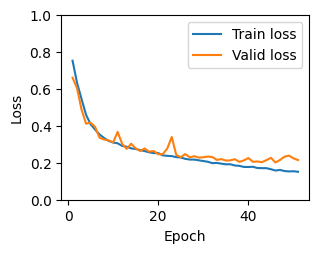

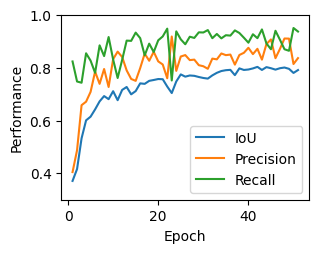

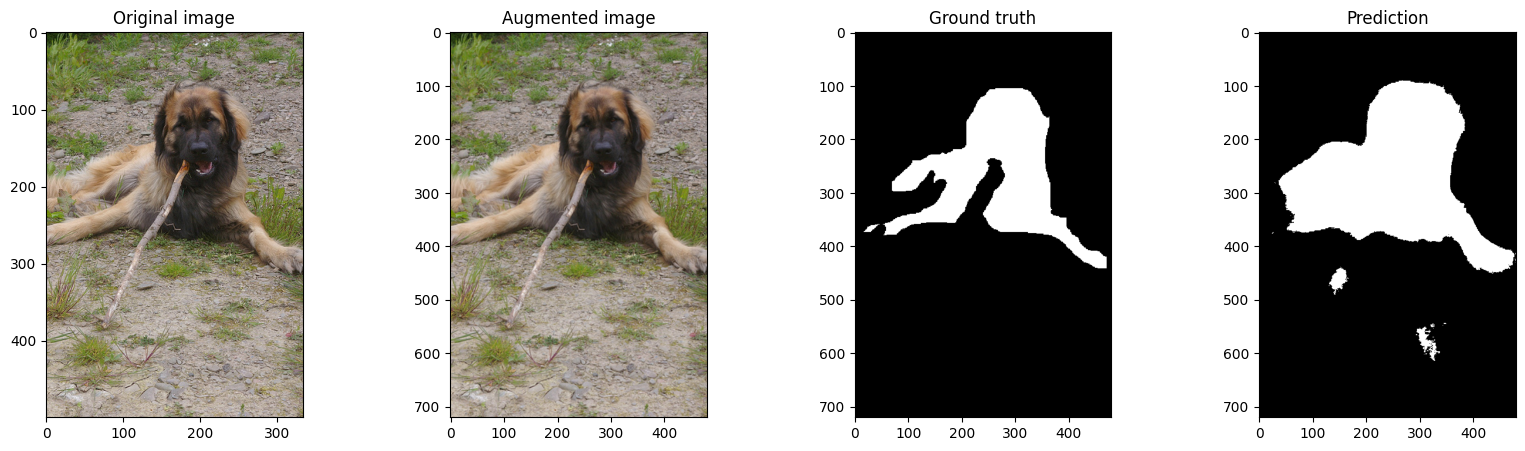

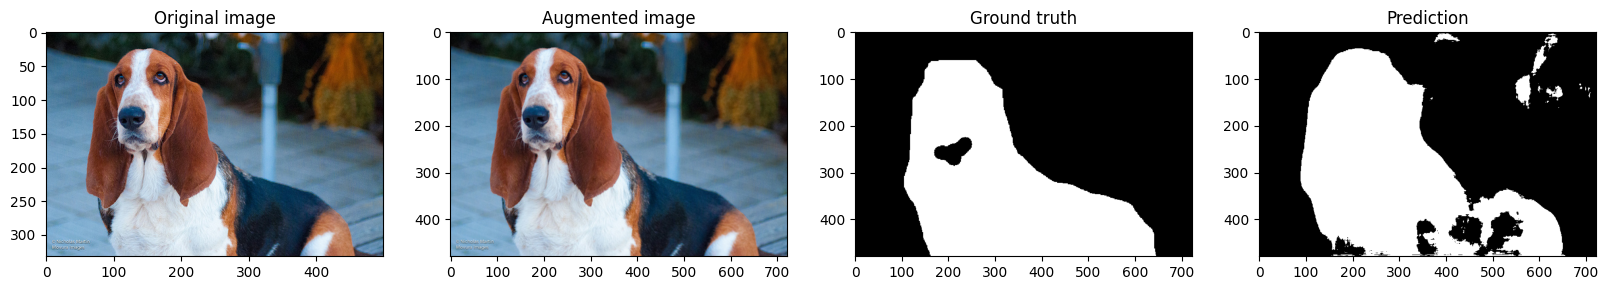

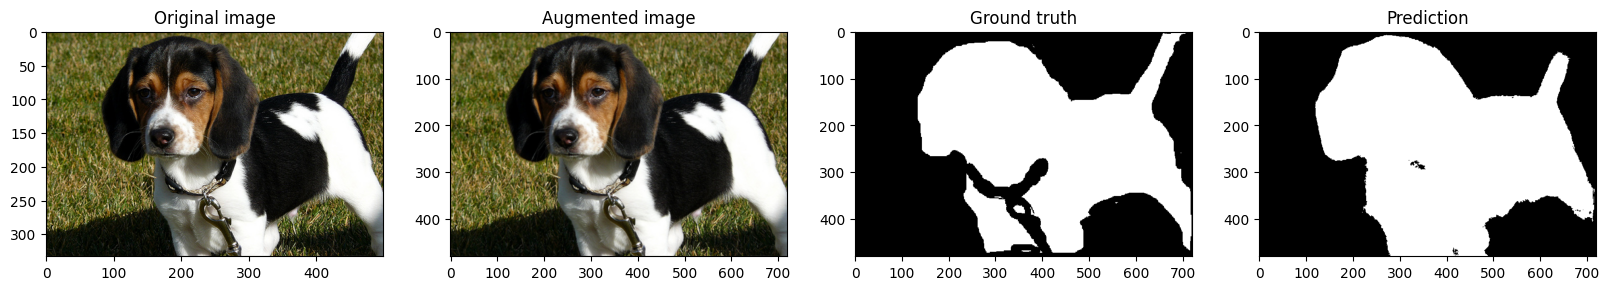

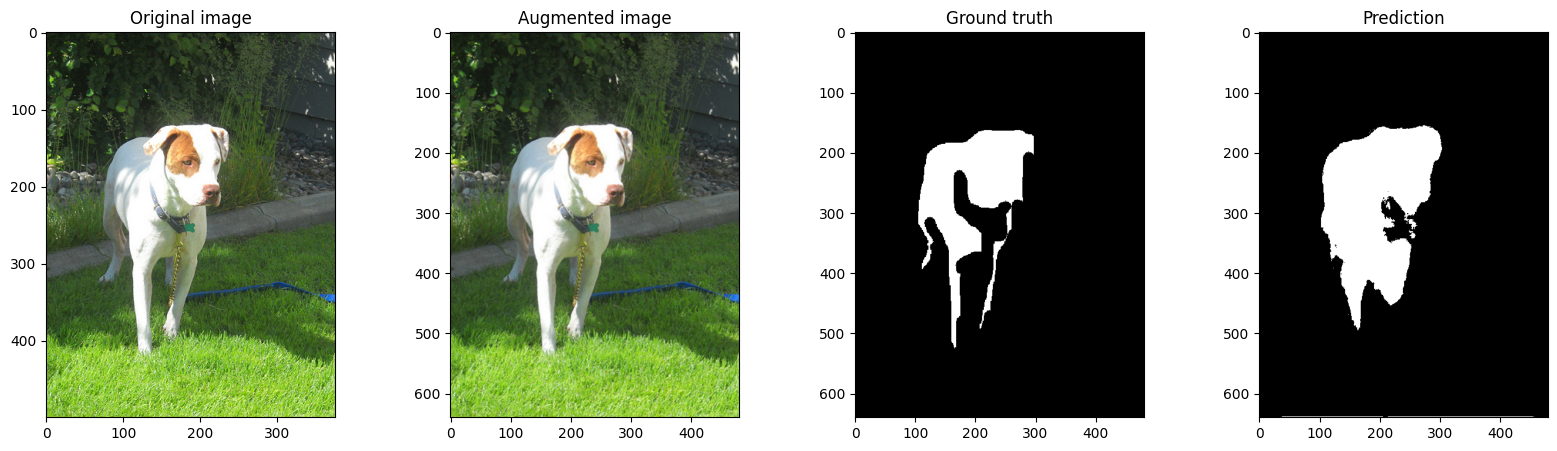

In [4]:
# Plot results
import random

def plot_metrics(logger, type='lt'):
    '''Plot losses and IoU. `lt` is the logger used in Lightning.'''

    if type=='lt':
        metrics = logger.metrics
        epochs, _ = zip(*metrics['val_loss'])
        metrics = [list(zip(*metrics[k]))[1] for k in ['train_loss', 'val_loss', 'iou', 'prec', 'rec']]
        train_loss, valid_loss, iou, prec, rec = metrics    
    elif type=='pt':
        epochs, metrics = zip(*logger.data.items())
        train_loss, valid_loss, iou, prec, rec = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.ylim((0, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.ylim((0.3, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')

def plot_examples(ds, model, n=4):
    """Plot some example segmentations"""

    model.eval()
    model.cuda()
    indices = random.sample(range(len(ds)),n)
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.getitem(idx)
        with torch.no_grad():
            y_pred = model(x[None].cuda())[0].cpu()
        x = x*0.2347+0.4394
        y_pred = torch.max(y_pred, dim=0)[1]

        plt.figure(figsize=[20,5])
        plt.subplot(1, 4, 1)
        plt.imshow(x_or, 'gray')
        plt.title('Original image')
        plt.subplot(1, 4, 2)
        plt.imshow(x.permute(1, 2, 0), 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 4, 3)
        plt.imshow(y==1, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred, 'gray')
        plt.title('Prediction')

#logger = trainer.loggers[1]
plot_metrics(logger, type='pt')
plot_examples(ds_valid, model)

In [ ]:
from recipes.dataset_readers import oxford_pets_classification
import torch
import matplotlib.pyplot as plt
import numpy as np

ds_train, ds_valid = oxford_pets_classification.create_datasets('../data', 0.1)

mean = torch.tensor([0.4394, 0.4394, 0.4394]).reshape(3, 1, 1)
std = torch.tensor([0.2347, 0.2347, 0.2347]).reshape(3, 1, 1)

for i in range(30,50):
    x, y = ds_train[i]
    x_or = ds_train.getitem(i)[0]

    x = x*std + mean

    plt.figure(figsize=[10,5])
    plt.subplot(1, 2, 1)
    plt.imshow(x_or)
    plt.title(y)
    plt.subplot(1, 2, 2)
    plt.imshow(x.permute(1, 2, 0))

In [7]:
# Check if output values are too large
model.eval()
model.to('cuda')
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        if idx%10==0:
            print(idx)
        output = model(x[None].to('cuda'))[0].to('cpu')
        stats.append((idx, output.min(), output.max()))
stats

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360


[(0, tensor(-9.8933), tensor(5.4667)),
 (1, tensor(-5.1422), tensor(4.3755)),
 (2, tensor(-7.0790), tensor(5.5563)),
 (3, tensor(-5.5306), tensor(4.0616)),
 (4, tensor(-4.6250), tensor(5.0775)),
 (5, tensor(-5.4248), tensor(6.0678)),
 (6, tensor(-4.7566), tensor(4.3371)),
 (7, tensor(-7.4968), tensor(3.2371)),
 (8, tensor(-5.4650), tensor(4.7163)),
 (9, tensor(-11.2845), tensor(6.7713)),
 (10, tensor(-4.8333), tensor(3.7312)),
 (11, tensor(-6.9309), tensor(5.4129)),
 (12, tensor(-6.4696), tensor(5.8608)),
 (13, tensor(-4.2359), tensor(4.7178)),
 (14, tensor(-4.7009), tensor(3.1058)),
 (15, tensor(-5.0610), tensor(4.2091)),
 (16, tensor(-6.8751), tensor(5.3531)),
 (17, tensor(-9.0713), tensor(4.4491)),
 (18, tensor(-8.9234), tensor(5.7301)),
 (19, tensor(-4.7984), tensor(4.0314)),
 (20, tensor(-6.0963), tensor(6.2896)),
 (21, tensor(-8.9326), tensor(5.1953)),
 (22, tensor(-9.6355), tensor(6.3797)),
 (23, tensor(-5.5810), tensor(5.3530)),
 (24, tensor(-4.9415), tensor(6.2794)),
 (25, ten

In [9]:
# Check performance
import torchtrainer
model.eval()
model.to('cuda')
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        output = model(x[None].to('cuda')).to('cpu')
        mask = torch.zeros_like(y[None], dtype=torch.bool)
        mask[y[None]!=255] = 1   # Ignore pixels with value 255
        acc = torchtrainer.perf_funcs.segmentation_accuracy(output, y[None], ('iou', 'prec', 'rec'), mask=mask)
        stats.append((idx, *list(acc.items())))
stats

[(0,
  ('iou', tensor(0.8527)),
  ('prec', tensor(0.8710)),
  ('rec', tensor(0.9758))),
 (1,
  ('iou', tensor(0.6372)),
  ('prec', tensor(0.7398)),
  ('rec', tensor(0.8213))),
 (2,
  ('iou', tensor(0.6335)),
  ('prec', tensor(0.6888)),
  ('rec', tensor(0.8876))),
 (3,
  ('iou', tensor(0.6743)),
  ('prec', tensor(0.7453)),
  ('rec', tensor(0.8762))),
 (4,
  ('iou', tensor(0.7817)),
  ('prec', tensor(0.8192)),
  ('rec', tensor(0.9447))),
 (5,
  ('iou', tensor(0.2808)),
  ('prec', tensor(0.2832)),
  ('rec', tensor(0.9714))),
 (6,
  ('iou', tensor(0.7817)),
  ('prec', tensor(0.9242)),
  ('rec', tensor(0.8352))),
 (7,
  ('iou', tensor(0.8488)),
  ('prec', tensor(0.8741)),
  ('rec', tensor(0.9670))),
 (8,
  ('iou', tensor(0.6653)),
  ('prec', tensor(0.9940)),
  ('rec', tensor(0.6680))),
 (9, ('iou', tensor(0.)), ('prec', tensor(0.)), ('rec', tensor(0.))),
 (10,
  ('iou', tensor(0.9240)),
  ('prec', tensor(0.9433)),
  ('rec', tensor(0.9783))),
 (11,
  ('iou', tensor(0.8265)),
  ('prec', tenso

In [10]:
# Check intermediate activations of the model
insp = torchtrainer.inspector.Inspector(model)
insp.start_tracking_activations()

model.eval()
model.to('cuda')
with torch.no_grad():
    output = model(ds_valid[0][0][None].to('cuda'))
acts = insp.get_activations()

stats = []
for k, v in acts.items():
    if v is not None:
        stats.append((k, v.min(), v.max()))
stats

[('resunet.conv1', tensor(-12.8745), tensor(11.2388)),
 ('resunet.bn1', tensor(-4.2790), tensor(3.7542)),
 ('resunet.relu', tensor(0.), tensor(3.7542)),
 ('resunet.encoder.stage_0.0.conv1', tensor(-9.6036), tensor(7.8649)),
 ('resunet.encoder.stage_0.0.bn1', tensor(-5.2811), tensor(4.9989)),
 ('resunet.encoder.stage_0.0.relu1', tensor(0.), tensor(4.9989)),
 ('resunet.encoder.stage_0.0.conv2', tensor(-5.1142), tensor(5.1655)),
 ('resunet.encoder.stage_0.0.bn2', tensor(-6.5755), tensor(7.1473)),
 ('resunet.encoder.stage_0.0.relu2', tensor(0.), tensor(7.9382)),
 ('resunet.encoder.stage_0.0.downsample.0', tensor(-7.7512), tensor(4.1030)),
 ('resunet.encoder.stage_0.0.downsample.1', tensor(-5.2555), tensor(7.0420)),
 ('resunet.encoder.stage_0.0.downsample', tensor(-5.2555), tensor(7.0420)),
 ('resunet.encoder.stage_0.0', tensor(0.), tensor(7.9382)),
 ('resunet.encoder.stage_0', tensor(0.), tensor(7.9382)),
 ('resunet.encoder.stage_1.0.conv1', tensor(-7.2679), tensor(8.9516)),
 ('resunet.enc